In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.3-py3-none-any.whl size=154726 sha256=4163a03a92833e7c0c8b0c36da4572d646b8056b204e57dae0421711bca56868
  Stored in directory: /root/.cache/pip/wheels/60/1e/04/b42e786399bd7503af674d1ec95d93665b1700309ec3525b65
Successfully built pyod


In [4]:
!pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42884 sha256=6ca744ba09885510abaad8c9abd31b9fa9bde302a53e095adc5618f3cd3a4a4a
  Stored in directory: /root/.cache/pip/wheels/b1/6e/c9/89dab355d4d5d58b11fe135b5839e8a3acc8b73273ffc68cde
Successfully built combo


In [5]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("white")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score,\
    silhouette_score, f1_score
from pyod.models import knn, lof, hbos, iforest,ocsvm


from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.feature_bagging import FeatureBagging
def train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
    print("Total time: ", span, "s.")

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test

def co_train_test(clf, X_train, X_test):
    # get the prediction label and outlier scores of the training data
    start = time.time()
    clf.fit(X_train)
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    end_train = time.time()
    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores
    end = time.time()
    time_to_train = end_train-start
    time_to_test = end-end_train
    span = end - start
#    print("Train time: ", time_to_train, "s.")
#    print("Test time: ", time_to_test, "s.")
    

    return y_train_pred, y_train_scores, y_test_pred, y_test_scores,clf.threshold_, time_to_train, time_to_test 

def my_metric(label,predict):
    CM = confusion_matrix(label,predict)
    CR = classification_report(label,predict)
    fpr, tpr, thresholds = roc_curve(label, predict)
    precision=precision_score(label, predict)
    recall=recall_score(label, predict)
    accuracy = accuracy_score(label, predict)
    f1=f1_score(label, predict, average='weighted')
    #AUC = auc(fpr, tpr)
    AUC=metrics.auc(fpr, tpr)

    results = {"Confusion Matrix":CM,"Classification Report":CR,"Area Under Curve":AUC}

    # show results
    for measure in results:
        print(measure,": \n",results[measure])
#     plt.plot(fpr, recall, 'k--', label='ROC (area = {0:.2f})'.format(AUC), lw=2)
    return fpr,tpr,f1,AUC, recall, accuracy
def baseline(X_train, X_test, y_train, y_test,model):
    start = time.time()

    if model == "knn":
        print ("Base Detector:"+model)
        clf = knn.KNN()
    elif model == "lof":
        print ("Base Detector:"+model)
        clf = lof.LOF()
    elif model == "hbos":
        print ("Base Detector:"+model)
        clf = hbos.HBOS()
    elif model == "iforest":
        print ("Base Detector:"+model)
        clf = iforest.IForest()
    elif model== "ocsvm":
        print ("Base Detector:"+model)
        clf = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test= train_test(clf, X_train, X_test)
    print("\nTraining set:\n")
    _, _, _, _ ,_, _ = my_metric(y_train, y_train_pred)
    print("\nTest set:\n")
    fpr, tpr, f1, auc, recall, accuracy= my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test, recall, accuracy
def feature_bagging(X_train, X_test, y_train, y_test,basemodel,combination_function="mean"):

    start = time.time()
    #print ("FB base detector:"+basemodel)


    # train Feature Bagging detector
    clf_name = 'FeatureBagging'
    if basemodel=="knn":
        base_estimator=knn.KNN()
    elif basemodel=="lof":
        base_estimator = lof.LOF()
    elif basemodel == "hbos":
        base_estimator = hbos.HBOS()
    elif basemodel == "iforest":
        base_estimator = iforest.IForest()
    elif basemodel== "ocsvm":
        base_estimator = ocsvm.OCSVM()
    else:
        print("Please select a correct base model!")
    if combination_function=="mean":
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False)
    else:
        clf = FeatureBagging(base_estimator=base_estimator,check_estimator=False,combination='max')
    # params
    clf.fit(X_train)

    print("Feature Bagging:")
    y_train_pred, y_train_scores, y_test_pred, y_test_scores, time_to_train, time_to_test = train_test(clf, X_train, X_test)
    print("training set:")
    _,_,_,_, _, _=my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("f1:",f1,"auc:",auc)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train, time_to_test,  recall, accuracy
def minmax(x):
    min=x.min()
    max=x.max()
    x = (x - min) / (max - min)
    return x,min,max
def parameter_ensemble(X_train, X_test, y_train, y_test,basemodel,combination_function="mean",span=10):
    #span :Determine the number of different parameters
    start = time.time()
    #print ("PR base detector:"+basemodel)
    threshold = []
    train_score=[]
    test_score=[]#np.zeros([X_test.shape[0],span])
    time_to_train=0
    time_to_test=0
    
    # for i in range(low, high + 1):
    for i in range(0, span):

        if basemodel == "knn":
            clf = knn.KNN(n_neighbors=i+5)
        elif basemodel == "lof":
            clf = lof.LOF(n_neighbors=i+20)
        elif basemodel == "hbos":
            clf = hbos.HBOS(n_bins=10+i)
        elif basemodel == "iforest":
            clf = iforest.IForest(n_estimators=i+100)
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM(degree=i+3)
        else:
            print("Please select a correct base model!")
        print("parameter ensemble:")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        #_, y_train_scores, y_test_pred, y_test_scores,threshold0, time_to_train0, time_to_test0= train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        _, _, f1, auc ,  recall, accuracy= my_metric(y_test, y_test_pred)

        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
    print("PE Total time: ", time_to_train+time_to_test, "s.") 
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    # threshold = threshold/span
    
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy =my_metric(y_train, y_train_pred)
    print("test set:")
    fpr,tpr,f1, auc , recall, accuracy= my_metric(y_test, y_test_pred)
    #print("f1:",f1,"auc:",auc)
    
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy

def gram_schmidt(data):
    r, c = data.shape
    data = data.astype("float64")
    data[:, 0] = data[:, 0] / np.linalg.norm(data[:, 0])
    for j in range(1, c):
        y = data[:, j]
        sum = np.zeros((r,))
        for i in range(j):
            sum += np.dot(y, data[:, i]) * data[:, i]
        y -= sum
        y = y / np.linalg.norm(y)
        data[:, j] = y
    return data

def rotated_bagging(X_train, X_test):
    n, d = X_train.shape
    r = int(np.ceil(np.sqrt(d) * 0.5) + 0)
    E = np.random.uniform(size=(d, r))
    E = gram_schmidt(E)
    return np.matmul(X_train, E),np.matmul(X_test, E)

def subsample(data,mul=1):
    n = data.shape[0]
    a = 1 if n <= 50 else 50 / n
    b = 1 if n < 1000 else 1000 / n
    f = np.random.uniform(a, b)
    data = shuffle(data)
    m = np.floor(f * n*mul).astype("int32")
    return data.iloc[0:m]


def roteted_bagging(X_train0, X_test0, y_train, y_test,basemodel,combination_function="mean",loop=10):
    #loop: The number of subsets(Sample some features)

    start = time.time()

    test_score =[]
    threshold=[]
    time_to_train=0
    time_to_test=0
    for i in range(loop):

        X_train, X_test = rotated_bagging(X_train0, X_test0)


        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        y_train_pred, y_train_scores, y_test_pred, y_test_scores, threshold0, time_to_train0, time_to_test0= co_train_test(clf, X_train, X_test)
        time_to_train=time_to_train+time_to_train0
        time_to_test=time_to_test+time_to_test0
        
        y_test_scores=np.expand_dims(y_test_scores,-1)
        y_test_scores,min,max=minmax(y_test_scores)
        threshold0=(threshold0-min)/(max-min)
        test_score.append(y_test_scores)
        threshold.append(threshold0)
        _, _, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)
    print("RB Total time: ", time_to_train+time_to_test, "s.")
    if combination_function=="mean":
        test_score = np.array(test_score).mean(0)
        threshold = np.array(threshold).mean()
    elif combination_function=="max":
        test_score = np.array(test_score).max(0)
        threshold = np.array(threshold).max()
    elif combination_function=="median":
        test_score =np.median(np.array(test_score),0)
        threshold = np.median(np.array(threshold),0)
    else:
        print("Please select a correct combination function!")
    y_test_pred = np.array(test_score > threshold).astype(np.int).flatten()
    
    print("training set:")
    fpr,tpr,f1, auc, recall, accuracy=my_metric(y_train, y_train_pred)
    print("test set:")
    #print("f1:",f1,"auc:",auc)
    fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, y_test_pred)

    end = time.time()
    times = end - start
    

    return fpr, tpr, f1, auc, time_to_train0, time_to_test0, recall, accuracy
def variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel,combination_function="mean",loop=30, threshold = 1.9,mul=1):
    #loop: The number of subsets(Sample some data points)
    #threshold: A threshold that determines whether the data is abnormal
    #mul: Controls the size of a subset

    start = time.time()
    n_train=X_train.shape[0]
    N = df.shape[0]

    df = pd.DataFrame(np.concatenate([X_train, X_test],0))
    target = pd.DataFrame(np.concatenate([y_train, y_test],0))
    X_index = df.index

    y_VR = np.zeros((N, 2))
    y_VR = pd.DataFrame(y_VR, index=X_index, columns=['score', 'times'])
    for i in range(loop):
        X_train = subsample(df,mul)
        save = X_train.index

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)

        n1 = X_train.shape[0]
        if basemodel == "knn":
            clf = knn.KNN()
        elif basemodel == "lof":
            clf = lof.LOF()
        elif basemodel == "hbos":
            clf = hbos.HBOS()
        elif basemodel == "iforest":
            clf = iforest.IForest()
        elif basemodel == "ocsvm":
            clf = ocsvm.OCSVM()
        else:
            print("Please select a correct base model!")

        clf.fit(X_train)
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        y_train_scores = y_train_scores[:, np.newaxis]
        scaler = StandardScaler()
        scaler.fit(y_train_scores)
        y_train_scores = scaler.transform(y_train_scores).flatten()

        if combination_function=="mean":
            y_VR.loc[save, "score"] += y_train_scores
        elif combination_function=="max":
            y_VR.loc[save, "score"] = np.max([y_train_scores,y_VR.loc[save, "score"]],0)
        else:
            print("Please select a correct combination function!")
        y_VR.loc[save, "times"] = y_VR.loc[save, "times"] + 1

    # if 0 in set(y_VR["times"]):
    #     # some points are not scored, we simply use a base method to the left data
    #     # we should avoid this situation
    #     has_test = True
    #     train_yvr = y_VR[y_VR["times"] != 0]
    #     test_index = y_VR[y_VR["times"] == 0].index
    #     if combination_function=="mean":
    #         train_score = train_yvr["score"] / train_yvr["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target.loc[train_yvr.index]
    #     X_test = df.loc[test_index]
    #     if X_test.shape[0] > 10:
    #         scaler = StandardScaler()
    #         scaler.fit(X_test)
    #         X_test = scaler.transform(X_test)
    #         y_test = target.loc[test_index]
    #
   #         clf = lof.LOF()
    #         clf.fit(X_test)
    #         test_pred = clf.labels_
    #     else:
    #         test_pred = np.zeros((X_test.shape[0], 1))
    # #     test_score = clf.decision_scores_
    #
    # else:
    #     has_test = False
    #     if combination_function=="mean":
    #         train_score = y_VR["score"] / y_VR["times"]
    #     elif combination_function=="max":
    #         train_score = y_VR["score"]
    #     else:
    #         print("Please select a correct combination function!")
    #     y_train = target
    has_test = False
    if combination_function=="mean":
        train_score = y_VR["score"] / y_VR["times"]
    elif combination_function=="max":
        train_score = y_VR["score"]
    else:
        print("Please select a correct combination function!")
    y_train = target

    # %%
    if not has_test:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        
   
    
        _, _, _, _,_, _= my_metric(target[:n_train], y_train_pred[:n_train])
        #fpr, tpr, f1, auc = my_metric(target[n_train:], y_pred[n_train:])
        fpr, tpr, f1, auc , recall, accuracy= my_metric(target[n_train:], y_train_pred[n_train:])

    else:
        y_train_pred = np.array(train_score > threshold).astype(np.int).flatten()
        _, _, _, _,_, _= my_metric(y_train, y_train_pred)
        fpr, tpr, f1, auc, recall, accuracy = my_metric(y_test, test_pred)

    end = time.time()
    times = end - start
#    print("Train time: ", 0.8*times, "s.")
#    print("Test time: ", 0.2*times, "s.")
    print("VR Total time: ", times, "s.")

    return fpr, tpr, f1, auc,0.5*times, 0.5*times,recall, accuracy



In [6]:
#import tensorflow as tf

In [7]:
# %%load data
window=100
paysim=pd.read_csv('../content/drive/MyDrive/thesis/data/paysim_downsized2.csv')



y_all = paysim["label"].values
df = paysim[paysim.columns[0:-1]]

data0 = df.values
data=data0[window-1:,:]
for j in range(1,window):
    #data=np.concatenate([data,data0[window-1-j:-j,1:-1]],axis=1)
    data=data+data0[window-1-j:-j,:]
df=data
target=y_all[window-1:]
target=pd.Series(target)

X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.5)
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [8]:
#knn
fpr_knn, tpr_knn, f1_knn, auc_knn,time_train_knn,time_test_knn, recall_knn, accuracy_knn=baseline(X_train, X_test, y_train, y_test,model="knn")


Base Detector:knn
Total time:  3.8385801315307617 s.

Training set:

Confusion Matrix : 
 [[24563  2574]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6990725759294395

Test set:

Confusion Matrix : 
 [[24688  2449]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7013757044992888


In [9]:
#feature bagging
fpr_fb_knn, tpr_fb_knn, f1_fb_knn, auc_fb_knn,time_train_fb_knn, time_test_fb_knn, recall_fb_knn, accuracy_fb_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Feature Bagging:
Total time:  37.740955114364624 s.
training set:
Confusion Matrix : 
 [[24580  2557]
 [  164   193]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.54      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.72      0.54     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7231953252244627
test set:
Confusion Matrix : 
 [[24780  2357]
 [  172   185]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.52      0.13       357

    accuracy                           0.91     27494
   macro avg       0.53      0.72      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7156758491435045
f1: 0.9407514895835277 auc: 0.7156

In [10]:
fpr_fb1_knn, tpr_fb1_knn, f1_fb1_knn, auc_fb1_knn,time_train_fb1_max_knn, time_test_fb1_max_knn, recall_fb1_knn, accuracy_fb1_knn=feature_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Feature Bagging:
Total time:  36.81025719642639 s.
training set:
Confusion Matrix : 
 [[24563  2574]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6990725759294395
test set:
Confusion Matrix : 
 [[24688  2449]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7013757044992888
f1: 0.9386336375694169 auc: 0.70137

In [11]:
#parameter ensemble
fpr_pe_knn, tpr_pe_knn, f1_pe_knn, auc_pe_knn,time_train_pe_knn, time_test_pe_knn, recall_pe_knn, accuracy_pe_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn")


parameter ensemble:
Confusion Matrix : 
 [[24688  2449]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7013757044992888
parameter ensemble:
Confusion Matrix : 
 [[24719  2418]
 [  179   178]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.50      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.70      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7047480008327907
parameter ensemble:
Confusion Matrix : 
 [[24636  2501]
 [  165   192]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [12]:

fpr_pe1_knn, tpr_pe1_knn, f1_pe1_knn, auc_pe1_knn,time_train_pe1_max_knn, time_test_pe1_max_knn, recall_pe1_knn, accuracy_pe1_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[24688  2449]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7013757044992888
parameter ensemble:
Confusion Matrix : 
 [[24719  2418]
 [  179   178]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.50      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.70      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7047480008327907
parameter ensemble:
Confusion Matrix : 
 [[24636  2501]
 [  165   192]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [13]:
fpr_pe2_knn, tpr_pe2_knn, f1_pe2_knn, auc_pe2_knn,time_train_pe2_median_knn, time_test_pe2_median_knn, recall_pe2_knn, accuracy_pe2_knn=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[24688  2449]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7013757044992888
parameter ensemble:
Confusion Matrix : 
 [[24719  2418]
 [  179   178]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.50      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.70      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7047480008327907
parameter ensemble:
Confusion Matrix : 
 [[24636  2501]
 [  165   192]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [14]:
#rotated bagging
fpr_rb_knn, tpr_rb_knn, f1_rb_knn, auc_rb_knn,time_train_rb_knn, time_test_rb_knn, recall_rb_knn, accuracy_rb_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn")


Confusion Matrix : 
 [[24651  2486]
 [  184   173]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.48      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6964922977703445
Confusion Matrix : 
 [[24469  2668]
 [  224   133]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.05      0.37      0.08       357

    accuracy                           0.89     27494
   macro avg       0.52      0.64      0.51     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.6371165336090585
Confusion Matrix : 
 [[24506  2631]
 [  178   179]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [15]:
fpr_rb1_knn, tpr_rb1_knn, f1_rb1_knn, auc_rb1_knn,time_train_rb1_max_knn, time_test_rb1_max_knn, recall_rb1_knn, accuracy_rb1_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="max")


Confusion Matrix : 
 [[24517  2620]
 [  172   185]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     27137
           1       0.07      0.52      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.71      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7108300666325416
Confusion Matrix : 
 [[24591  2546]
 [  215   142]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.40      0.09       357

    accuracy                           0.90     27494
   macro avg       0.52      0.65      0.52     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6519694291100381
Confusion Matrix : 
 [[24604  2533]
 [  258    99]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:
fpr_rb2_knn, tpr_rb2_knn, f1_rb2_knn, auc_rb2_knn,time_train_rb2_median_knn, time_test_rb2_median_knn, recall_rb2_knn, accuracy_rb2_knn=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="knn",combination_function="median")


Confusion Matrix : 
 [[24619  2518]
 [  226   131]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.37      0.09       357

    accuracy                           0.90     27494
   macro avg       0.52      0.64      0.52     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6370791674446983
Confusion Matrix : 
 [[24531  2606]
 [  278    79]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.22      0.05       357

    accuracy                           0.90     27494
   macro avg       0.51      0.56      0.50     27494
weighted avg       0.98      0.90      0.93     27494

Area Under Curve : 
 0.5626286332788634
Confusion Matrix : 
 [[24697  2440]
 [  179   178]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [17]:
#variable sampling with rotated bagging
fpr_vr_knn, tpr_vr_knn, f1_vr_knn, auc_vr_knn,time_train_vr_knn, time_test_vr_knn, recall_vr_knn, accuracy_vr_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",threshold=1.2,loop=100)


Confusion Matrix : 
 [[26209   928]
 [  238   119]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     27137
           1       0.11      0.33      0.17       357

    accuracy                           0.96     27494
   macro avg       0.55      0.65      0.57     27494
weighted avg       0.98      0.96      0.97     27494

Area Under Curve : 
 0.6495682401641055
Confusion Matrix : 
 [[26162   975]
 [  245   112]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     27137
           1       0.10      0.31      0.16       357

    accuracy                           0.96     27494
   macro avg       0.55      0.64      0.57     27494
weighted avg       0.98      0.96      0.97     27494

Area Under Curve : 
 0.6388983422532147
VR Total time:  1.528003215789795 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [18]:

fpr_vr1_knn, tpr_vr1_knn, f1_vr1_knn, auc_vr1_knn,time_train_vr1_max_knn, time_test_vr1_max_knn, recall_vr1_knn, accuracy_vr1_knn=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="knn",combination_function="max",threshold=1.2,loop=100)


Confusion Matrix : 
 [[26166   971]
 [  230   127]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     27137
           1       0.12      0.36      0.17       357

    accuracy                           0.96     27494
   macro avg       0.55      0.66      0.58     27494
weighted avg       0.98      0.96      0.97     27494

Area Under Curve : 
 0.6599804457287946
Confusion Matrix : 
 [[26160   977]
 [  238   119]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     27137
           1       0.11      0.33      0.16       357

    accuracy                           0.96     27494
   macro avg       0.55      0.65      0.57     27494
weighted avg       0.98      0.96      0.97     27494

Area Under Curve : 
 0.6486654137647246
VR Total time:  1.3250868320465088 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


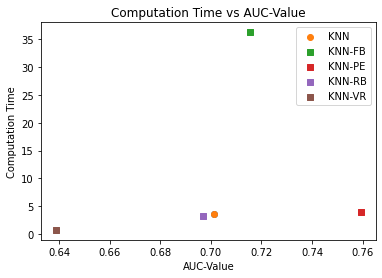

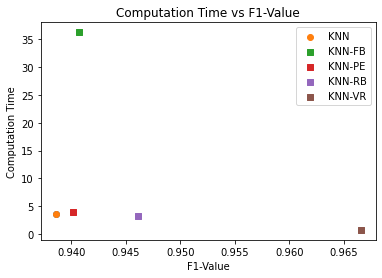

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


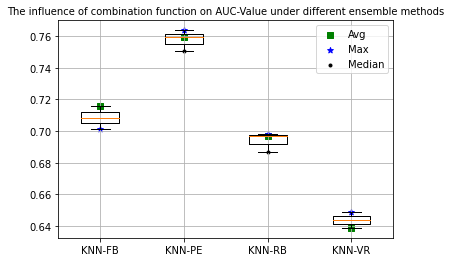

In [19]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_knn,auc_fb_knn, auc_pe_knn, auc_rb_knn , auc_vr_knn]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_knn,f1_fb_knn, f1_pe_knn, f1_rb_knn , f1_vr_knn]
y = [time_test_knn,time_test_fb_knn, time_test_pe_knn, time_test_rb_knn, time_test_vr_knn]
ax.scatter(x, y)  
txt = ['KNN', 'KNN-FB',  'KNN-PE', 'KNN-RB', 'KNN-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='KNN-FB', "KNN-PE", 'KNN-RB','KNN-VR'

A = [auc_fb_knn,auc_fb1_knn]
B = [auc_pe_knn, auc_pe1_knn, auc_pe2_knn]
C = [auc_rb_knn, auc_rb1_knn, auc_rb2_knn]
D = [auc_vr_knn,auc_vr1_knn]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_knn,auc_pe_knn,auc_rb_knn,auc_vr_knn],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_knn,auc_pe1_knn,auc_rb1_knn,auc_vr1_knn],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_knn,auc_rb2_knn],label="Median",marker='.',c='k')

plt.legend()
plt.show()


In [20]:
#########################LOF
#lof
fpr_lof, tpr_lof, f1_lof, auc_lof,time_train_lof,time_test_lof, recall_lof, accuracy_lof=baseline(X_train, X_test, y_train, y_test,model="lof")


Base Detector:lof
Total time:  1.2090973854064941 s.

Training set:

Confusion Matrix : 
 [[24499  2638]
 [  245   112]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.04      0.31      0.07       357

    accuracy                           0.90     27494
   macro avg       0.52      0.61      0.51     27494
weighted avg       0.98      0.90      0.93     27494

Area Under Curve : 
 0.6082575197599399

Test set:

Confusion Matrix : 
 [[24357  2780]
 [  259    98]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.27      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5860333225673362


In [21]:
#feature bagging
fpr_fb_lof, tpr_fb_lof, f1_fb_lof, auc_fb_lof,time_train_fb_lof,time_test_fb_lof, recall_fb_lof, accuracy_fb_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Feature Bagging:
Total time:  11.16247010231018 s.
training set:
Confusion Matrix : 
 [[24514  2623]
 [  230   127]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     27137
           1       0.05      0.36      0.08       357

    accuracy                           0.90     27494
   macro avg       0.52      0.63      0.51     27494
weighted avg       0.98      0.90      0.93     27494

Area Under Curve : 
 0.6295422985496664
test set:
Confusion Matrix : 
 [[24378  2759]
 [  250   107]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.04      0.30      0.07       357

    accuracy                           0.89     27494
   macro avg       0.51      0.60      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5990252901838776
f1: 0.9305041946462979 auc: 0.59902

In [22]:
fpr_fb1_lof, tpr_fb1_lof, f1_fb1_lof, auc_fb1_lof,time_train_fb1_max_lof,time_test_fb1_max_lof, recall_fb1_lof, accuracy_fb1_lof=feature_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Feature Bagging:
Total time:  7.48378849029541 s.
training set:
Confusion Matrix : 
 [[24495  2642]
 [  249   108]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.04      0.30      0.07       357

    accuracy                           0.89     27494
   macro avg       0.51      0.60      0.51     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.6025815787493463
test set:
Confusion Matrix : 
 [[24490  2647]
 [  260    97]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.04      0.27      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5870832911415662
f1: 0.9325295533296344 auc: 0.587083

In [23]:
#parameter ensemble
fpr_pe_lof, tpr_pe_lof, f1_pe_lof, auc_pe_lof,time_train_pe_lof,time_test_pe_lof, recall_pe_lof, accuracy_pe_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof")


parameter ensemble:
Confusion Matrix : 
 [[24357  2780]
 [  259    98]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.27      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5860333225673362
parameter ensemble:
Confusion Matrix : 
 [[24351  2786]
 [  256   101]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.28      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5901244530682523
parameter ensemble:
Confusion Matrix : 
 [[24382  2755]
 [  258    99]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [24]:
fpr_pe1_lof, tpr_pe1_lof, f1_pe1_lof, auc_pe1_lof,time_train_pe1_max_lof,time_test_pe1_max_lof, recall_pe1_lof, accuracy_pe1_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[24357  2780]
 [  259    98]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.27      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5860333225673362
parameter ensemble:
Confusion Matrix : 
 [[24351  2786]
 [  256   101]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.28      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5901244530682523
parameter ensemble:
Confusion Matrix : 
 [[24382  2755]
 [  258    99]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [25]:
fpr_pe2_lof, tpr_pe2_lof, f1_pe2_lof, auc_pe2_lof,time_train_pe2_median_lof,time_test_pe2_median_lof, recall_pe2_lof, accuracy_pe2_lof=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[24357  2780]
 [  259    98]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.27      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5860333225673362
parameter ensemble:
Confusion Matrix : 
 [[24351  2786]
 [  256   101]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.28      0.06       357

    accuracy                           0.89     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5901244530682523
parameter ensemble:
Confusion Matrix : 
 [[24382  2755]
 [  258    99]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [26]:
#rotated bagging
fpr_rb_lof, tpr_rb_lof, f1_rb_lof, auc_rb_lof,time_train_rb_lof,time_test_rb_lof, recall_rb_lof, accuracy_rb_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof")


Confusion Matrix : 
 [[24189  2948]
 [  252   105]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.03      0.29      0.06       357

    accuracy                           0.88     27494
   macro avg       0.51      0.59      0.50     27494
weighted avg       0.98      0.88      0.93     27494

Area Under Curve : 
 0.5927418393380863
Confusion Matrix : 
 [[24154  2983]
 [  225   132]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.04      0.37      0.08       357

    accuracy                           0.88     27494
   macro avg       0.52      0.63      0.51     27494
weighted avg       0.98      0.88      0.93     27494

Area Under Curve : 
 0.6299120893889487
Confusion Matrix : 
 [[24235  2902]
 [  257   100]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [27]:
fpr_rb1_lof, tpr_rb1_lof, f1_rb1_lof, auc_rb1_lof,time_train_rb1_max_lof,time_test_rb1_max_lof, recall_rb1_lof, accuracy_rb1_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="max")


Confusion Matrix : 
 [[24181  2956]
 [  245   112]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.04      0.31      0.07       357

    accuracy                           0.88     27494
   macro avg       0.51      0.60      0.50     27494
weighted avg       0.98      0.88      0.93     27494

Area Under Curve : 
 0.6023983606782434
Confusion Matrix : 
 [[24156  2981]
 [  248   109]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.04      0.31      0.06       357

    accuracy                           0.88     27494
   macro avg       0.51      0.60      0.50     27494
weighted avg       0.98      0.88      0.93     27494

Area Under Curve : 
 0.5977360542920046
Confusion Matrix : 
 [[24238  2899]
 [  283    74]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [28]:
fpr_rb2_lof, tpr_rb2_lof, f1_rb2_lof, auc_rb2_lof,time_train_rb2_median_lof,time_test_rb2_median_lof, recall_rb2_lof, accuracy_rb2_lof=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="lof",combination_function="median")


Confusion Matrix : 
 [[24112  3025]
 [  285    72]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.02      0.20      0.04       357

    accuracy                           0.88     27494
   macro avg       0.51      0.55      0.49     27494
weighted avg       0.98      0.88      0.92     27494

Area Under Curve : 
 0.5451046247441012
Confusion Matrix : 
 [[24138  2999]
 [  281    76]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.02      0.21      0.04       357

    accuracy                           0.88     27494
   macro avg       0.51      0.55      0.49     27494
weighted avg       0.98      0.88      0.92     27494

Area Under Curve : 
 0.5511859163829883
Confusion Matrix : 
 [[24135  3002]
 [  245   112]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [29]:
#variable sampling with rotated bagging
fpr_vr_lof, tpr_vr_lof, f1_vr_lof, auc_vr_lof,time_train_vr_lof,time_test_vr_lof, recall_vr_lof, accuracy_vr_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof", loop=100)


Confusion Matrix : 
 [[26478   659]
 [  284    73]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     27137
           1       0.10      0.20      0.13       357

    accuracy                           0.97     27494
   macro avg       0.54      0.59      0.56     27494
weighted avg       0.98      0.97      0.97     27494

Area Under Curve : 
 0.5900988025382979
Confusion Matrix : 
 [[26429   708]
 [  278    79]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     27137
           1       0.10      0.22      0.14       357

    accuracy                           0.96     27494
   macro avg       0.54      0.60      0.56     27494
weighted avg       0.98      0.96      0.97     27494

Area Under Curve : 
 0.597599337483455
VR Total time:  1.5619800090789795 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [30]:
fpr_vr1_lof, tpr_vr1_lof, f1_vr1_lof, auc_vr1_lof,time_train_vr1_max_lof,time_test_vr1_max_lof, recall_vr1_lof, accuracy_vr1_lof=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="lof",combination_function="max",loop=100,mul=100)


Confusion Matrix : 
 [[23152  3985]
 [  152   205]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     27137
           1       0.05      0.57      0.09       357

    accuracy                           0.85     27494
   macro avg       0.52      0.71      0.50     27494
weighted avg       0.98      0.85      0.91     27494

Area Under Curve : 
 0.7136911071315801
Confusion Matrix : 
 [[23097  4040]
 [  166   191]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     27137
           1       0.05      0.54      0.08       357

    accuracy                           0.85     27494
   macro avg       0.52      0.69      0.50     27494
weighted avg       0.98      0.85      0.91     27494

Area Under Curve : 
 0.6930698874235915
VR Total time:  66.28087162971497 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


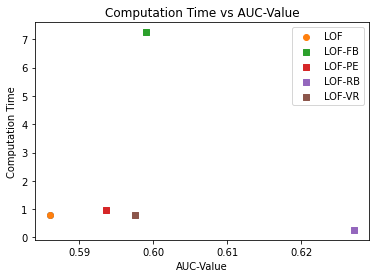

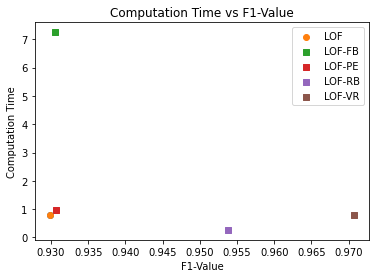

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


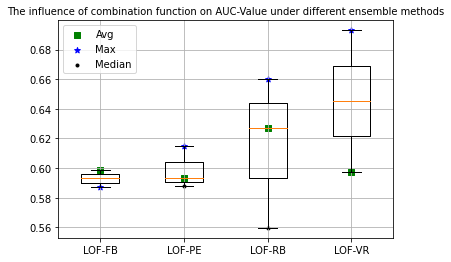

In [31]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_lof,auc_fb_lof, auc_pe_lof, auc_rb_lof , auc_vr_lof]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_lof,f1_fb_lof, f1_pe_lof, f1_rb_lof , f1_vr_lof]
y = [time_test_lof,time_test_fb_lof, time_test_pe_lof, time_test_rb_lof, time_test_vr_lof]
ax.scatter(x, y)  
txt = ['LOF', 'LOF-FB',  'LOF-PE', 'LOF-RB', 'LOF-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='LOF-FB', "LOF-PE", 'LOF-RB','LOF-VR'
A = [auc_fb_lof,auc_fb1_lof]
B = [auc_pe_lof, auc_pe1_lof, auc_pe2_lof]
C = [auc_rb_lof, auc_rb1_lof, auc_rb2_lof]
D = [auc_vr_lof,auc_vr1_lof]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_lof,auc_pe_lof,auc_rb_lof,auc_vr_lof],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_lof,auc_pe1_lof,auc_rb1_lof,auc_vr1_lof],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_lof,auc_rb2_lof],label="Median",marker='.',c='k')

plt.legend()
plt.show()



In [32]:
##################################HBOS
#hbos
fpr_hbos, tpr_hbos, f1_hbos, auc_hbos,time_train_hbos,time_test_hbos, recall_hbos, accuracy_hbos=baseline(X_train, X_test, y_train, y_test,model="hbos")


Base Detector:hbos
Total time:  2.0926380157470703 s.

Training set:

Confusion Matrix : 
 [[24625  2512]
 [  174   183]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.51      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.71      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7100188492687122

Test set:

Confusion Matrix : 
 [[24710  2427]
 [  172   185]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.52      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.71      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7143860971443889


In [33]:
#feature bagging
fpr_fb_hbos, tpr_fb_hbos, f1_fb_hbos, auc_fb_hbos,time_train_fb_hbos,time_test_fb_hbos, recall_fb_hbos, accuracy_fb_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Feature Bagging:
Total time:  0.1635911464691162 s.
training set:
Confusion Matrix : 
 [[24584  2553]
 [  168   189]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.53      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.72      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7176667844423393
test set:
Confusion Matrix : 
 [[24659  2478]
 [  163   194]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.54      0.13       357

    accuracy                           0.90     27494
   macro avg       0.53      0.73      0.54     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7260514627046971
f1: 0.9385100716983066 auc: 0.7260

In [34]:
fpr_fb1_hbos, tpr_fb1_hbos, f1_fb1_hbos, auc_fb1_hbos,time_train_fb1_max_hbos,time_test_fb1_max_hbos, recall_fb1_hbos, accuracy_fb1_hbos=feature_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Feature Bagging:
Total time:  0.17995452880859375 s.
training set:
Confusion Matrix : 
 [[24625  2512]
 [  174   183]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.51      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.71      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7100188492687122
test set:
Confusion Matrix : 
 [[24710  2427]
 [  172   185]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.52      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.71      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7143860971443889
f1: 0.9393197422342182 auc: 0.714

In [35]:
#parameter ensemble
fpr_pe_hbos, tpr_pe_hbos, f1_pe_hbos, auc_pe_hbos,time_train_pe_hbos,time_test_pe_hbos, recall_pe_hbos, accuracy_pe_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos")


parameter ensemble:
Confusion Matrix : 
 [[24710  2427]
 [  172   185]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.52      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.71      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7143860971443889
parameter ensemble:
Confusion Matrix : 
 [[24594  2543]
 [  158   199]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.56      0.13       357

    accuracy                           0.90     27494
   macro avg       0.53      0.73      0.54     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7318566369688237
parameter ensemble:
Confusion Matrix : 
 [[24614  2523]
 [  165   192]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [36]:
fpr_pe1_hbos, tpr_pe1_hbos, f1_pe1_hbos, auc_pe1_hbos,time_train_pe1_max_hbos,time_test_pe1_max_hbos, recall_pe1_hbos, accuracy_pe1_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[24710  2427]
 [  172   185]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.52      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.71      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7143860971443889
parameter ensemble:
Confusion Matrix : 
 [[24594  2543]
 [  158   199]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.56      0.13       357

    accuracy                           0.90     27494
   macro avg       0.53      0.73      0.54     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7318566369688237
parameter ensemble:
Confusion Matrix : 
 [[24614  2523]
 [  165   192]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [37]:
fpr_pe2_hbos, tpr_pe2_hbos, f1_pe2_hbos, auc_pe2_hbos,time_train_pe2_median_hbos,time_test_pe2_median_hbos, recall_pe2_hbos, accuracy_pe2_hbos=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[24710  2427]
 [  172   185]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.52      0.12       357

    accuracy                           0.91     27494
   macro avg       0.53      0.71      0.54     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.7143860971443889
parameter ensemble:
Confusion Matrix : 
 [[24594  2543]
 [  158   199]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.56      0.13       357

    accuracy                           0.90     27494
   macro avg       0.53      0.73      0.54     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7318566369688237
parameter ensemble:
Confusion Matrix : 
 [[24614  2523]
 [  165   192]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [38]:
#rotated bagging
fpr_rb_hbos, tpr_rb_hbos, f1_rb_hbos, auc_rb_hbos,time_train_rb_hbos,time_test_rb_hbos, recall_rb_hbos, accuracy_rb_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos")


Confusion Matrix : 
 [[24808  2329]
 [  251   106]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.04      0.30      0.08       357

    accuracy                           0.91     27494
   macro avg       0.52      0.61      0.51     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.6055474922400697
Confusion Matrix : 
 [[24825  2312]
 [  284    73]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.03      0.20      0.05       357

    accuracy                           0.91     27494
   macro avg       0.51      0.56      0.50     27494
weighted avg       0.98      0.91      0.94     27494

Area Under Curve : 
 0.5596422303306111
Confusion Matrix : 
 [[24846  2291]
 [  245   112]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [39]:
fpr_rb1_hbos, tpr_rb1_hbos, f1_rb1_hbos, auc_rb1_hbos,time_train_rb1_max_hbos,time_test_rb1_max_hbos, recall_rb1_hbos, accuracy_rb1_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="max")


Confusion Matrix : 
 [[24712  2425]
 [  227   130]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.36      0.09       357

    accuracy                           0.90     27494
   macro avg       0.52      0.64      0.52     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6373921348765766
Confusion Matrix : 
 [[24603  2534]
 [  234   123]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.34      0.08       357

    accuracy                           0.90     27494
   macro avg       0.52      0.63      0.51     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6255798851950406
Confusion Matrix : 
 [[24931  2206]
 [  211   146]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [40]:
fpr_rb2_hbos, tpr_rb2_hbos, f1_rb2_hbos, auc_rb2_hbos,time_train_rb2_median_hbos,time_test_rb2_median_hbos, recall_rb2_hbos, accuracy_rb2_hbos=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="hbos",combination_function="median")


Confusion Matrix : 
 [[24627  2510]
 [  200   157]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.44      0.10       357

    accuracy                           0.90     27494
   macro avg       0.53      0.67      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6736411334994993
Confusion Matrix : 
 [[24657  2480]
 [  237   120]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.34      0.08       357

    accuracy                           0.90     27494
   macro avg       0.52      0.62      0.51     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6223731560649466
Confusion Matrix : 
 [[24770  2367]
 [  201   156]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [41]:
#variable sampling with rotated bagging
fpr_vr_hbos, tpr_vr_hbos, f1_vr_hbos, auc_vr_hbos,time_train_vr_hbos,time_test_vr_hbos, recall_vr_hbos, accuracy_vr_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",loop=100,mul=100)


Confusion Matrix : 
 [[26070  1067]
 [  216   141]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     27137
           1       0.12      0.39      0.18       357

    accuracy                           0.95     27494
   macro avg       0.55      0.68      0.58     27494
weighted avg       0.98      0.95      0.97     27494

Area Under Curve : 
 0.6778194861244051
Confusion Matrix : 
 [[26041  1096]
 [  213   144]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.98     27137
           1       0.12      0.40      0.18       357

    accuracy                           0.95     27494
   macro avg       0.55      0.68      0.58     27494
weighted avg       0.98      0.95      0.97     27494

Area Under Curve : 
 0.681486840968469
VR Total time:  4.465609073638916 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [42]:
fpr_vr1_hbos, tpr_vr1_hbos, f1_vr1_hbos, auc_vr1_hbos,time_train_vr1_max_hbos,time_test_vr1_max_hbos, recall_vr1_hbos, accuracy_vr1_hbos=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="hbos",combination_function="max",loop=100,mul=100)



Confusion Matrix : 
 [[25945  1192]
 [  212   145]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97     27137
           1       0.11      0.41      0.17       357

    accuracy                           0.95     27494
   macro avg       0.55      0.68      0.57     27494
weighted avg       0.98      0.95      0.96     27494

Area Under Curve : 
 0.6811185984509144
Confusion Matrix : 
 [[25920  1217]
 [  207   150]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97     27137
           1       0.11      0.42      0.17       357

    accuracy                           0.95     27494
   macro avg       0.55      0.69      0.57     27494
weighted avg       0.98      0.95      0.96     27494

Area Under Curve : 
 0.6876607738573927
VR Total time:  4.178454875946045 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


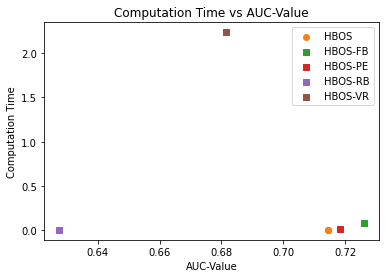

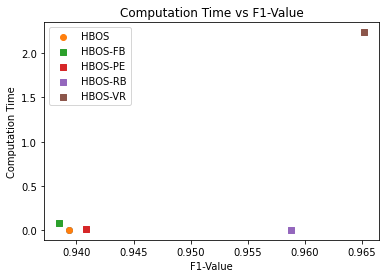

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


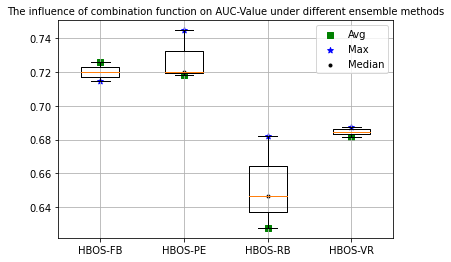

In [43]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_hbos,auc_fb_hbos, auc_pe_hbos, auc_rb_hbos , auc_vr_hbos]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_hbos,f1_fb_hbos, f1_pe_hbos, f1_rb_hbos , f1_vr_hbos]
y = [time_test_hbos,time_test_fb_hbos, time_test_pe_hbos, time_test_rb_hbos, time_test_vr_hbos]
ax.scatter(x, y)  
txt = ['HBOS', 'HBOS-FB',  'HBOS-PE', 'HBOS-RB', 'HBOS-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()
#######

labels ='HBOS-FB', "HBOS-PE", 'HBOS-RB','HBOS-VR'
A = [auc_fb_hbos,auc_fb1_hbos]
B = [auc_pe_hbos, auc_pe1_hbos, auc_pe2_hbos]
C = [auc_rb_hbos, auc_rb1_hbos, auc_rb2_hbos]
D = [auc_vr_hbos,auc_vr1_hbos]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_hbos,auc_pe_hbos,auc_rb_hbos,auc_vr_hbos],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_hbos,auc_pe1_hbos,auc_rb1_hbos,auc_vr1_hbos],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_hbos,auc_rb2_hbos],label="Median",marker='.',c='k')
plt.legend()
plt.show()

In [44]:
# ##################################One-Class SVM
#ocsvm
fpr_ocsvm, tpr_ocsvm, f1_ocsvm, auc_ocsvm,time_train_ocsvm,time_test_ocsvm, recall_ocsvm, accuracy_ocsvm =baseline(X_train, X_test, y_train, y_test,model="ocsvm")


Base Detector:ocsvm
Total time:  97.17234206199646 s.

Training set:

Confusion Matrix : 
 [[24564  2573]
 [  180   177]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.50      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7004915611820879

Test set:

Confusion Matrix : 
 [[24617  2520]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7000675274716144


In [45]:
#feature bagging
fpr_fb_ocsvm, tpr_fb_ocsvm, f1_fb_ocsvm, auc_fb_ocsvm,time_train_fb_ocsvm,time_test_fb_ocsvm, recall_fb_ocsvm, accuracy_fb_ocsvm =feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Feature Bagging:
Total time:  957.1370525360107 s.
training set:
Confusion Matrix : 
 [[24559  2578]
 [  185   172]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.48      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.69      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6933966349188458
test set:
Confusion Matrix : 
 [[24552  2585]
 [  184   173]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     27137
           1       0.06      0.48      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.69      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6946682199430239
f1: 0.9357703788771703 auc: 0.69466

In [46]:
fpr_fb1_ocsvm, tpr_fb1_ocsvm, f1_fb1_ocsvm, auc_fb1_ocsvm,time_train_fb1_max_ocsvm,time_test_fb1_max_ocsvm, recall_fb1_ocsvm, accuracy_fb1_ocsvm=feature_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Feature Bagging:
Total time:  954.2055208683014 s.
training set:
Confusion Matrix : 
 [[24575  2562]
 [  169   188]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.53      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.72      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7161003989612206
test set:
Confusion Matrix : 
 [[24639  2498]
 [  171   186]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.52      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.71      0.54     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7144784803408041
f1: 0.9378915893062606 auc: 0.71447

In [47]:
#parameter ensemble
fpr_pe_ocsvm, tpr_pe_ocsvm, f1_pe_ocsvm, auc_pe_ocsvm,time_train_pe_ocsvm,time_test_pe_ocsvm, recall_pe_ocsvm, accuracy_pe_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm")


parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7000675274716144
parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7000675274716144
parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [48]:
fpr_pe1_ocsvm, tpr_pe1_ocsvm, f1_pe1_ocsvm, auc_pe1_ocsvm,time_train_pe1_max_ocsvm,time_test_pe1_max_ocsvm, recall_pe1_ocsvm, accuracy_pe1_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7000675274716144
parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7000675274716144
parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [49]:
fpr_pe2_ocsvm, tpr_pe2_ocsvm, f1_pe2_ocsvm, auc_pe2_ocsvm,time_train_pe2_median_ocsvm,time_test_pe2_median_ocsvm, recall_pe2_ocsvm, accuracy_pe2_ocsvm=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7000675274716144
parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.49      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7000675274716144
parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  181   176]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [50]:
#rotated bagging
fpr_rb_ocsvm, tpr_rb_ocsvm, f1_rb_ocsvm, auc_rb_ocsvm,time_train_rb_ocsvm,time_test_rb_ocsvm, recall_rb_ocsvm, accuracy_rb_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm")


Confusion Matrix : 
 [[24541  2596]
 [  225   132]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     27137
           1       0.05      0.37      0.09       357

    accuracy                           0.90     27494
   macro avg       0.52      0.64      0.52     27494
weighted avg       0.98      0.90      0.93     27494

Area Under Curve : 
 0.637042575441202
Confusion Matrix : 
 [[24574  2563]
 [  220   137]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.38      0.09       357

    accuracy                           0.90     27494
   macro avg       0.52      0.64      0.52     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6446534025040904
Confusion Matrix : 
 [[24508  2629]
 [  268    89]]
Classification Report : 
               precision    recall

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [51]:
fpr_rb1_ocsvm, tpr_rb1_ocsvm, f1_rb1_ocsvm, auc_rb1_ocsvm,time_train_rb1_max_ocsvm,time_test_rb1_max_ocsvm, recall_rb1_ocsvm, accuracy_rb1_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="max")


Confusion Matrix : 
 [[24521  2616]
 [  149   208]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     27137
           1       0.07      0.58      0.13       357

    accuracy                           0.90     27494
   macro avg       0.53      0.74      0.54     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7431166519008385
Confusion Matrix : 
 [[24466  2671]
 [  274    83]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     27137
           1       0.03      0.23      0.05       357

    accuracy                           0.89     27494
   macro avg       0.51      0.57      0.50     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.5670332473189003
Confusion Matrix : 
 [[24626  2511]
 [  239   118]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [52]:
fpr_rb2_ocsvm, tpr_rb2_ocsvm, f1_rb2_ocsvm, auc_rb2_ocsvm,time_train_rb2_median_ocsvm,time_test_rb2_median_ocsvm, recall_rb2_ocsvm, accuracy_rb2_ocsvm=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="ocsvm",combination_function="median")


Confusion Matrix : 
 [[24607  2530]
 [  197   160]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.45      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.68      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6774743136005923
Confusion Matrix : 
 [[24628  2509]
 [  190   167]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.47      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.69      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6876651607689545
Confusion Matrix : 
 [[24633  2504]
 [  205   152]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [53]:
#variable sampling with rotated bagging
fpr_vr_ocsvm, tpr_vr_ocsvm, f1_vr_ocsvm, auc_vr_ocsvm,time_train_vr_ocsvm,time_test_vr_ocsvm, recall_vr_ocsvm, accuracy_vr_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",threshold=1.2,loop=100)


Confusion Matrix : 
 [[25397  1740]
 [  254   103]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     27137
           1       0.06      0.29      0.09       357

    accuracy                           0.93     27494
   macro avg       0.52      0.61      0.53     27494
weighted avg       0.98      0.93      0.95     27494

Area Under Curve : 
 0.6121981533889305
Confusion Matrix : 
 [[25471  1666]
 [  247   110]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     27137
           1       0.06      0.31      0.10       357

    accuracy                           0.93     27494
   macro avg       0.53      0.62      0.53     27494
weighted avg       0.98      0.93      0.95     27494

Area Under Curve : 
 0.6233655270709086
VR Total time:  3.320615291595459 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [54]:
fpr_vr1_ocsvm, tpr_vr1_ocsvm, f1_vr1_ocsvm, auc_vr1_ocsvm,time_train_vr1_max_ocsvm,time_test_vr1_max_ocsvm, recall_vr1_ocsvm, accuracy_vr1_ocsvm=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="ocsvm",combination_function="max",threshold=1.2,loop=50,mul=30)


Confusion Matrix : 
 [[24207  2930]
 [  170   187]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.06      0.52      0.11       357

    accuracy                           0.89     27494
   macro avg       0.53      0.71      0.52     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.7079194282274947
Confusion Matrix : 
 [[24257  2880]
 [  176   181]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     27137
           1       0.06      0.51      0.11       357

    accuracy                           0.89     27494
   macro avg       0.53      0.70      0.52     27494
weighted avg       0.98      0.89      0.93     27494

Area Under Curve : 
 0.7004373183108966
VR Total time:  1292.9688200950623 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


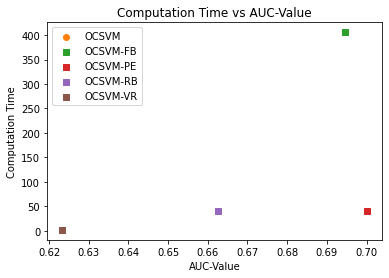

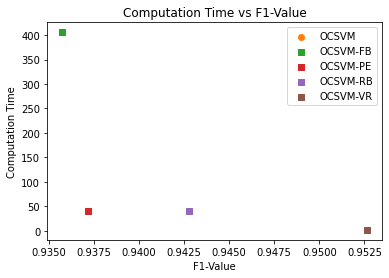

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


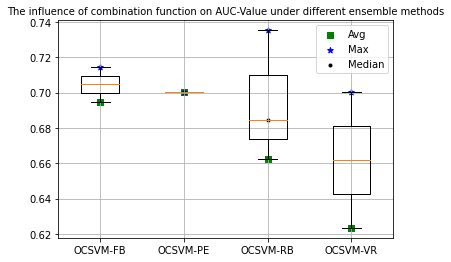

In [55]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ocsvm,auc_fb_ocsvm, auc_pe_ocsvm, auc_rb_ocsvm , auc_vr_ocsvm]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ocsvm,f1_fb_ocsvm, f1_pe_ocsvm, f1_rb_ocsvm , f1_vr_ocsvm]
y = [time_test_ocsvm,time_test_fb_ocsvm, time_test_pe_ocsvm, time_test_rb_ocsvm, time_test_vr_ocsvm]
ax.scatter(x, y)  
txt = ['OCSVM', 'OCSVM-FB',  'OCSVM-PE', 'OCSVM-RB', 'OCSVM-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='OCSVM-FB', "OCSVM-PE", 'OCSVM-RB','OCSVM-VR'

A = [auc_fb_ocsvm,auc_fb1_ocsvm]
B = [auc_pe_ocsvm, auc_pe1_ocsvm, auc_pe2_ocsvm]
C = [auc_rb_ocsvm, auc_rb1_ocsvm, auc_rb2_ocsvm]
D = [auc_vr_ocsvm,auc_vr1_ocsvm]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ocsvm,auc_pe_ocsvm,auc_rb_ocsvm,auc_vr_ocsvm],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ocsvm,auc_pe1_ocsvm,auc_rb1_ocsvm,auc_vr1_ocsvm],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ocsvm,auc_rb2_ocsvm],label="Median",marker='.',c='k')
#
plt.legend()
plt.show()


In [56]:
##################################IForest
#iforest
fpr_ifo, tpr_ifo, f1_ifo, auc_ifo,time_train_ifo,time_test_ifo,recall_ifo, accuracy_ifo =baseline(X_train, X_test, y_train, y_test,model="iforest")


Base Detector:iforest
Total time:  3.5978825092315674 s.

Training set:

Confusion Matrix : 
 [[24562  2575]
 [  182   175]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.697653590676791

Test set:

Confusion Matrix : 
 [[24553  2584]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6988883256438516


In [57]:
#feature bagging
fpr_fb_ifo, tpr_fb_ifo, f1_fb_ifo, auc_fb_ifo,time_train_fb_ifo,time_test_fb_ifo,recall_fb_ifo, accuracy_fb_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Feature Bagging:
Total time:  34.8097939491272 s.
training set:
Confusion Matrix : 
 [[24562  2575]
 [  182   175]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.697653590676791
test set:
Confusion Matrix : 
 [[24602  2535]
 [  178   179]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.50      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7039928327155014
f1: 0.9369510727331094 auc: 0.7039928

In [58]:
fpr_fb1_ifo, tpr_fb1_ifo, f1_fb1_ifo, auc_fb1_ifo,time_train_fb1_max_ifo,time_test_fb1_max_ifo,recall_fb1_ifo, accuracy_fb1_ifo=feature_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Feature Bagging:
Total time:  35.51560115814209 s.
training set:
Confusion Matrix : 
 [[24563  2574]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6990725759294395
test set:
Confusion Matrix : 
 [[24574  2563]
 [  183   174]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.696474130795407
f1: 0.9362473387420427 auc: 0.696474

In [59]:
#parameter ensemble
fpr_pe_ifo, tpr_pe_ifo, f1_pe_ifo, auc_pe_ifo,time_train_pe_ifo,time_test_pe_ifo,recall_pe_ifo, accuracy_pe_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest")


parameter ensemble:
Confusion Matrix : 
 [[24569  2568]
 [  178   179]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.50      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7033848067730611
parameter ensemble:
Confusion Matrix : 
 [[24577  2560]
 [  186   171]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.48      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.69      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6923277252088145
parameter ensemble:
Confusion Matrix : 
 [[24618  2519]
 [  178   179]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [60]:
fpr_pe1_ifo, tpr_pe1_ifo, f1_pe1_ifo, auc_pe1_ifo,time_train_pe1_max_ifo,time_test_pe1_max_ifo,recall_pe1_ifo, accuracy_pe1_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


parameter ensemble:
Confusion Matrix : 
 [[24582  2555]
 [  189   168]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.47      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.69      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6882181696793396
parameter ensemble:
Confusion Matrix : 
 [[24574  2563]
 [  180   177]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.50      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7006758114676759
parameter ensemble:
Confusion Matrix : 
 [[24617  2520]
 [  188   169]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [61]:
fpr_pe2_ifo, tpr_pe2_ifo, f1_pe2_ifo, auc_pe2_ifo,time_train_pe2_median_ifo,time_test_pe2_median_ifo,recall_pe2_ifo, accuracy_pe2_ifo=parameter_ensemble(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


parameter ensemble:
Confusion Matrix : 
 [[24565  2572]
 [  187   170]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.48      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.69      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6907060646420192
parameter ensemble:
Confusion Matrix : 
 [[24584  2553]
 [  181   176]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.06      0.49      0.11       357

    accuracy                           0.90     27494
   macro avg       0.53      0.70      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6994595015291741
parameter ensemble:
Confusion Matrix : 
 [[24628  2509]
 [  182   175]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:209: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [62]:
#rotated bagging
fpr_rb_ifo, tpr_rb_ifo, f1_rb_ifo, auc_rb_ifo,time_train_rb_ifo,time_test_rb_ifo,recall_rb_ifo, accuracy_rb_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest")


Confusion Matrix : 
 [[24649  2488]
 [  175   182]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.07      0.51      0.12       357

    accuracy                           0.90     27494
   macro avg       0.53      0.71      0.53     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.7090604897300334
Confusion Matrix : 
 [[24515  2622]
 [  207   150]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     27137
           1       0.05      0.42      0.10       357

    accuracy                           0.90     27494
   macro avg       0.52      0.66      0.52     27494
weighted avg       0.98      0.90      0.93     27494

Area Under Curve : 
 0.6617736087322869
Confusion Matrix : 
 [[24626  2511]
 [  192   165]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [63]:
fpr_rb1_ifo, tpr_rb1_ifo, f1_rb1_ifo, auc_rb1_ifo,time_train_rb1_max_ifo,time_test_rb1_max_ifo,recall_rb1_ifo, accuracy_rb1_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="max")


Confusion Matrix : 
 [[24566  2571]
 [  232   125]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.35      0.08       357

    accuracy                           0.90     27494
   macro avg       0.52      0.63      0.51     27494
weighted avg       0.98      0.90      0.93     27494

Area Under Curve : 
 0.6276992795865445
Confusion Matrix : 
 [[24588  2549]
 [  231   126]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.35      0.08       357

    accuracy                           0.90     27494
   macro avg       0.52      0.63      0.51     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6295051904389276
Confusion Matrix : 
 [[24620  2517]
 [  193   164]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [64]:
fpr_rb2_ifo, tpr_rb2_ifo, f1_rb2_ifo, auc_rb2_ifo,time_train_rb2_median_ifo,time_test_rb2_median_ifo,recall_rb2_ifo, accuracy_rb2_ifo=roteted_bagging(X_train, X_test, y_train, y_test,basemodel="iforest",combination_function="median")


Confusion Matrix : 
 [[24652  2485]
 [  232   125]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.35      0.08       357

    accuracy                           0.90     27494
   macro avg       0.52      0.63      0.52     27494
weighted avg       0.98      0.90      0.94     27494

Area Under Curve : 
 0.6292838320426007
Confusion Matrix : 
 [[24571  2566]
 [  235   122]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     27137
           1       0.05      0.34      0.08       357

    accuracy                           0.90     27494
   macro avg       0.52      0.62      0.51     27494
weighted avg       0.98      0.90      0.93     27494

Area Under Curve : 
 0.6235897240570695
Confusion Matrix : 
 [[24503  2634]
 [  264    93]]
Classification Report : 
               precision    recal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:296: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [65]:
#variable sampling with rotated bagging
fpr_vr_ifo, tpr_vr_ifo, f1_vr_ifo, auc_vr_ifo,time_train_vr_ifo,time_test_vr_ifo,recall_vr_ifo, accuracy_vr_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",threshold=1.2,loop=100)


Confusion Matrix : 
 [[25207  1930]
 [  232   125]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     27137
           1       0.06      0.35      0.10       357

    accuracy                           0.92     27494
   macro avg       0.53      0.64      0.53     27494
weighted avg       0.98      0.92      0.95     27494

Area Under Curve : 
 0.6395097228927316
Confusion Matrix : 
 [[25294  1843]
 [  234   123]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     27137
           1       0.06      0.34      0.11       357

    accuracy                           0.92     27494
   macro avg       0.53      0.64      0.53     27494
weighted avg       0.98      0.92      0.95     27494

Area Under Curve : 
 0.6383115799291674
VR Total time:  27.273045539855957 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [66]:
fpr_vr1_ifo, tpr_vr1_ifo, f1_vr1_ifo, auc_vr1_ifo,time_train_vr1_max_ifo,time_test_vr1_max_ifo,recall_vr1_ifo, accuracy_vr1_ifo=variable_sampling_with_rotated_bagging(X_train, X_test, y_train, y_test,df,basemodel="iforest",combination_function="max",threshold=1.2,loop=100,mul=100)


Confusion Matrix : 
 [[22447  4690]
 [  141   216]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     27137
           1       0.04      0.61      0.08       357

    accuracy                           0.82     27494
   macro avg       0.52      0.72      0.49     27494
weighted avg       0.98      0.82      0.89     27494

Area Under Curve : 
 0.7161076244626162
Confusion Matrix : 
 [[22472  4665]
 [  145   212]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     27137
           1       0.04      0.59      0.08       357

    accuracy                           0.83     27494
   macro avg       0.52      0.71      0.49     27494
weighted avg       0.98      0.83      0.89     27494

Area Under Curve : 
 0.7109660092802276
VR Total time:  302.7810163497925 s.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:410: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


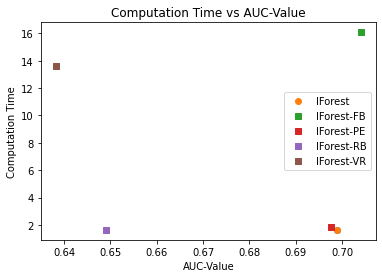

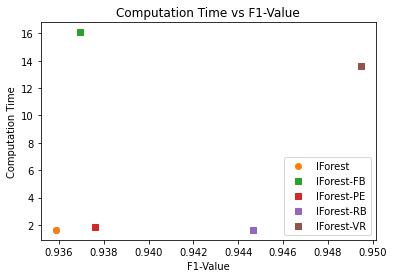

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


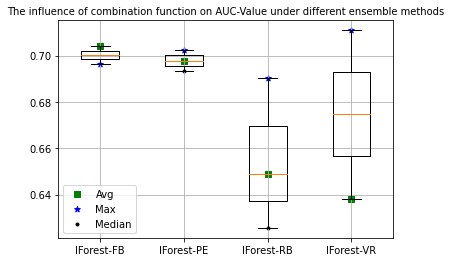

In [67]:
## computation time vs auc-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [auc_ifo,auc_fb_ifo, auc_pe_ifo, auc_rb_ifo , auc_vr_ifo]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs AUC-Value')
plt.xlabel('AUC-Value')
plt.ylabel('Computation Time')
plt.legend()
plt.show()
##computation time vs f1-value ##
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
x = [f1_ifo,f1_fb_ifo, f1_pe_ifo, f1_rb_ifo , f1_vr_ifo]
y = [time_test_ifo,time_test_fb_ifo, time_test_pe_ifo, time_test_rb_ifo, time_test_vr_ifo]
ax.scatter(x, y)  
txt = ['IForest', 'IForest-FB',  'IForest-PE', 'IForest-RB', 'IForest-VR']
for i in range(len(x)):
    if i < 1:
        plt.scatter(x[i], y[i], label=txt[i])
    else:
        plt.scatter(x[i], y[i], marker='s', label=txt[i])
ax.set_title('Computation Time vs F1-Value')

plt.xlabel('F1-Value')

plt.ylabel('Computation Time')
plt.legend()
plt.show()


labels ='IForest-FB', "IForest-PE", 'IForest-RB','IForest-VR'

A = [auc_fb_ifo,auc_fb1_ifo]
B = [auc_pe_ifo, auc_pe1_ifo, auc_pe2_ifo]
C = [auc_rb_ifo, auc_rb1_ifo, auc_rb2_ifo]
D = [auc_vr_ifo,auc_vr1_ifo]
plt.grid(True)  
plt.title('The influence of combination function on AUC-Value under different ensemble methods',fontdict={'weight':'normal','size': 10})
plt.boxplot([A, B,C,D],
            # meanprops={'color': 'blue', 'ls': '--', 'linewidth': '1.5'},
            flierprops={"marker": "o", "markerfacecolor": "red", "markersize": 10,},
            labels=labels)
ax = fig.add_subplot(111)
plt.scatter([1,2,3,4],[auc_fb_ifo,auc_pe_ifo,auc_rb_ifo,auc_vr_ifo],label="Avg",marker='s',c='g')
plt.scatter([1,2,3,4],[auc_fb1_ifo,auc_pe1_ifo,auc_rb1_ifo,auc_vr1_ifo],label="Max",marker='*',c='b')
plt.scatter([2,3], [auc_pe2_ifo,auc_rb2_ifo],label="Median",marker='.',c='k')

plt.legend()
plt.show()


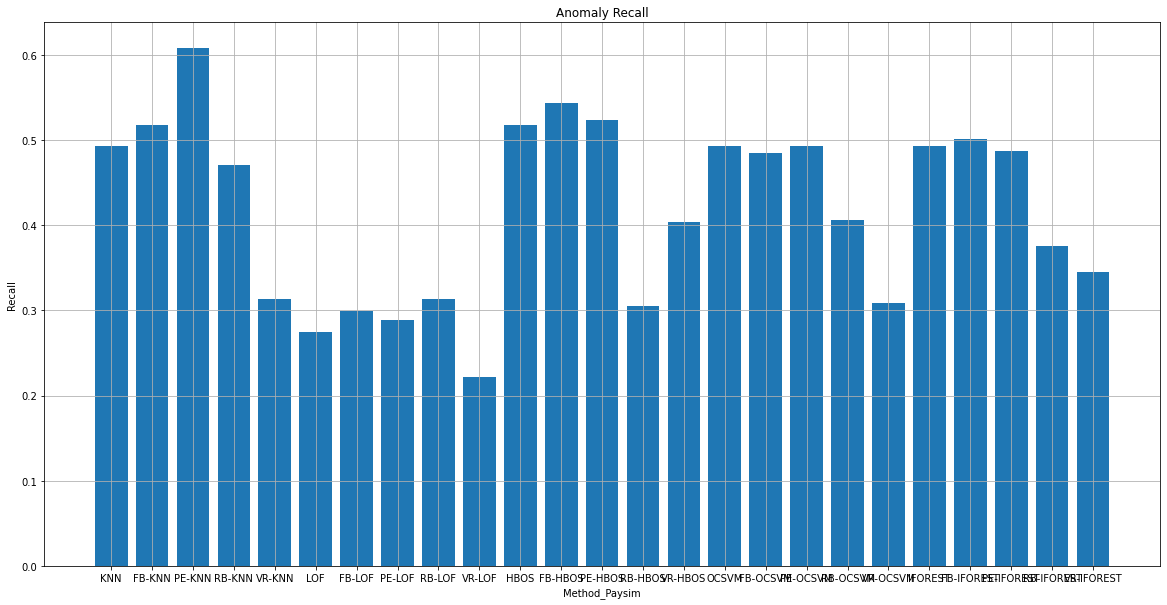

In [68]:
## recall ##
fig = plt.figure(figsize=(20, 10))

y = [recall_knn,recall_fb_knn,recall_pe_knn,recall_rb_knn,recall_vr_knn,
     recall_lof,recall_fb_lof,recall_pe_lof,recall_rb_lof,recall_vr_lof,
     recall_hbos,recall_fb_hbos,recall_pe_hbos,recall_rb_hbos,recall_vr_hbos,
     recall_ocsvm,recall_fb_ocsvm,recall_pe_ocsvm,recall_rb_ocsvm,recall_vr_ocsvm,
     recall_ifo,recall_fb_ifo,recall_pe_ifo,recall_rb_ifo,recall_vr_ifo]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST']

fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Anomaly Recall")
plt.xlabel("Method_Paysim")
plt.ylabel("Recall")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()




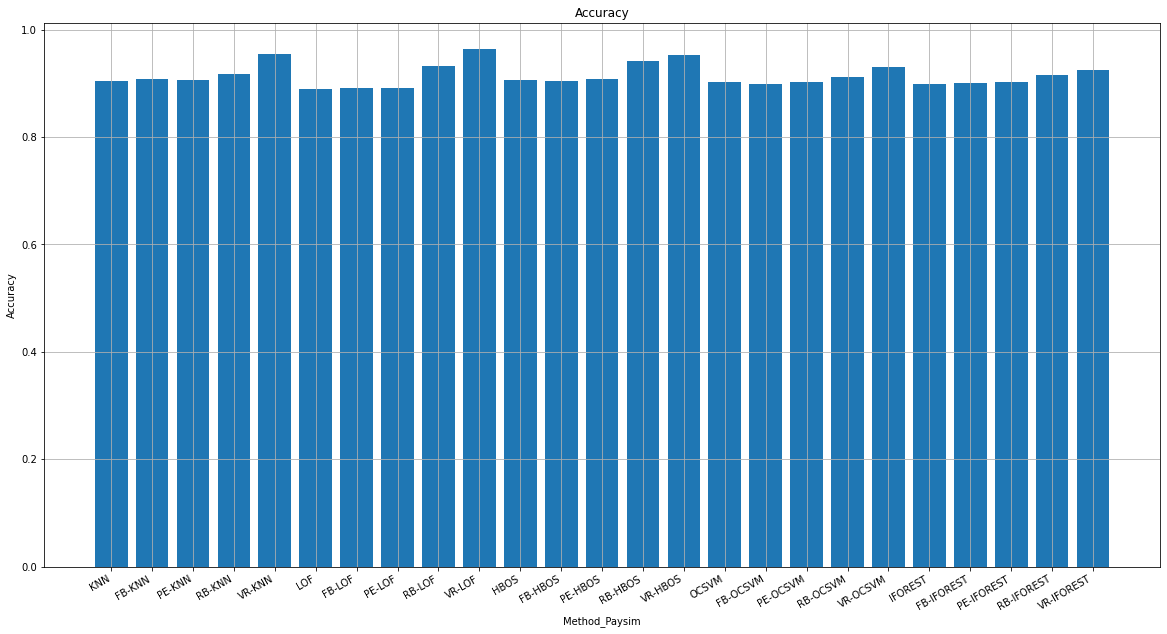

In [69]:
## Accuracy ##
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10


y = [accuracy_knn,accuracy_fb_knn,accuracy_pe_knn,accuracy_rb_knn,accuracy_vr_knn,
     accuracy_lof,accuracy_fb_lof,accuracy_pe_lof,accuracy_rb_lof,accuracy_vr_lof,
     accuracy_hbos,accuracy_fb_hbos,accuracy_pe_hbos,accuracy_rb_hbos,accuracy_vr_hbos,
     accuracy_ocsvm,accuracy_fb_ocsvm,accuracy_pe_ocsvm,accuracy_rb_ocsvm,accuracy_vr_ocsvm,
     accuracy_ifo,accuracy_fb_ifo,accuracy_pe_ifo,accuracy_rb_ifo,accuracy_vr_ifo]
x = ['KNN','FB-KNN','PE-KNN','RB-KNN','VR-KNN',
     'LOF','FB-LOF','PE-LOF','RB-LOF','VR-LOF',
     'HBOS','FB-HBOS','PE-HBOS','RB-HBOS','VR-HBOS',
     'OCSVM','FB-OCSVM','PE-OCSVM','RB-OCSVM','VR-OCSVM',
     'IFOREST','FB-IFOREST','PE-IFOREST','RB-IFOREST','VR-IFOREST']

ax= plt.subplot()
fig = plt.bar(x,y)
#plt.xticks(x,y)
plt.title("Accuracy")
plt.xlabel("Method_Paysim")
plt.ylabel("Accuracy")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.grid()
plt.show()

In [70]:
model_performance = pd.DataFrame(columns=['Accuracy','Recall','AUC','F1-Score','total time'])

model_performance.loc['KNN'] = [accuracy_knn, recall_knn, auc_knn, f1_knn,time_test_knn+time_train_knn]
model_performance.loc['FB-KNN_MEAN'] = [accuracy_fb_knn, recall_fb_knn, auc_fb_knn, f1_fb_knn,time_test_fb_knn+time_train_fb_knn]
model_performance.loc['FB-KNN_MAX'] = [accuracy_fb1_knn, recall_fb1_knn, auc_fb1_knn, f1_fb1_knn,time_test_fb1_max_knn+time_train_fb1_max_knn]
model_performance.loc['PE-KNN_MEAN'] = [accuracy_pe_knn, recall_pe_knn, auc_pe_knn, f1_pe_knn,time_test_pe_knn+time_train_pe_knn]
model_performance.loc['PE-KNN_MAX'] = [accuracy_pe1_knn, recall_pe1_knn, auc_pe1_knn, f1_pe1_knn,time_test_pe1_max_knn+time_train_pe1_max_knn]
model_performance.loc['PE-KNN_MEDIAN'] = [accuracy_pe2_knn, recall_pe2_knn, auc_pe2_knn, f1_pe2_knn,time_test_pe2_median_knn+time_train_pe2_median_knn]
model_performance.loc['RB-KNN_MEAN'] = [accuracy_rb_knn, recall_rb_knn, auc_rb_knn, f1_rb_knn,time_test_rb_knn+time_train_rb_knn]
model_performance.loc['RB-KNN_MAX'] = [accuracy_rb1_knn, recall_rb1_knn, auc_rb1_knn, f1_rb1_knn,time_test_rb1_max_knn+time_train_rb1_max_knn]
model_performance.loc['RB-KNN_MEDIAN'] = [accuracy_rb2_knn, recall_rb2_knn, auc_rb2_knn, f1_rb2_knn,time_test_rb2_median_knn+time_train_rb2_median_knn]
model_performance.loc['VR-KNN_MEAN'] = [accuracy_vr_knn, recall_vr_knn, auc_vr_knn, f1_vr_knn,time_test_vr_knn+time_train_vr_knn]
model_performance.loc['VR-KNN_MAX'] = [accuracy_vr1_knn, recall_vr1_knn, auc_vr1_knn, f1_vr1_knn,time_test_vr1_max_knn+time_train_vr1_max_knn]

model_performance.loc['LOF'] = [accuracy_lof, recall_lof, auc_lof, f1_lof,time_test_lof+time_train_lof]
model_performance.loc['FB-LOF_MEAN'] = [accuracy_fb_lof, recall_fb_lof, auc_fb_lof, f1_fb_lof,time_test_fb_lof+time_train_fb_lof]
model_performance.loc['FB-LOF_MAX'] = [accuracy_fb1_lof, recall_fb1_lof, auc_fb1_lof, f1_fb1_lof,time_test_fb1_max_lof+time_train_fb1_max_lof]
model_performance.loc['PE-LOF_MEAN'] = [accuracy_pe_lof, recall_pe_lof, auc_pe_lof, f1_pe_lof,time_test_pe_lof+time_train_pe_lof]
model_performance.loc['PE-LOF_MAX'] = [accuracy_pe1_lof, recall_pe1_lof, auc_pe1_lof, f1_pe1_lof,time_test_pe1_max_lof+time_train_pe1_max_lof]
model_performance.loc['PE-LOF_MEDIAN'] = [accuracy_pe2_lof, recall_pe2_lof, auc_pe2_lof, f1_pe2_lof,time_test_pe2_median_lof+time_train_pe2_median_lof]
model_performance.loc['RB-LOF_MEAN'] = [accuracy_rb_lof, recall_rb_lof, auc_rb_lof, f1_rb_lof,time_test_rb_lof+time_train_rb_lof]
model_performance.loc['RB-LOF_MAX'] = [accuracy_rb1_lof, recall_rb1_lof, auc_rb1_lof, f1_rb1_lof,time_test_rb1_max_lof+time_train_rb1_max_lof]
model_performance.loc['RB-LOF_MEDIAN'] = [accuracy_rb2_lof, recall_rb2_lof, auc_rb2_lof, f1_rb2_lof,time_test_rb2_median_lof+time_train_rb2_median_lof]
model_performance.loc['VR-LOF_MEAN'] = [accuracy_vr_lof, recall_vr_lof, auc_vr_lof, f1_vr_lof,time_test_vr_lof+time_train_vr_lof]
model_performance.loc['VR-LOF_MAX'] = [accuracy_vr1_lof, recall_vr1_lof, auc_vr1_lof, f1_vr1_lof,time_test_vr1_max_lof+time_train_vr1_max_lof]

model_performance.loc['HBOS'] = [accuracy_hbos, recall_hbos, auc_hbos, f1_hbos,time_test_hbos+time_train_hbos]
model_performance.loc['FB-HBOS_MEAN'] = [accuracy_fb_hbos, recall_fb_hbos, auc_fb_hbos, f1_fb_hbos,time_test_fb_hbos+time_train_fb_hbos]
model_performance.loc['FB-HBOS_MAX'] = [accuracy_fb1_hbos, recall_fb1_hbos, auc_fb1_hbos, f1_fb1_hbos,time_test_fb1_max_hbos+time_train_fb1_max_hbos]
model_performance.loc['PE-HBOS_MEAN'] = [accuracy_pe_hbos, recall_pe_hbos, auc_pe_hbos, f1_pe_hbos,time_test_pe_hbos+time_train_pe_hbos]
model_performance.loc['PE-HBOS_MAX'] = [accuracy_pe1_hbos, recall_pe1_hbos, auc_pe1_hbos, f1_pe1_hbos,time_test_pe1_max_hbos+time_train_pe1_max_hbos]
model_performance.loc['PE-HBOS_MEDIAN'] = [accuracy_pe2_hbos, recall_pe2_hbos, auc_pe2_hbos, f1_pe2_hbos,time_test_pe2_median_hbos+time_train_pe2_median_hbos]
model_performance.loc['RB-HBOS_MEAN'] = [accuracy_rb_hbos, recall_rb_hbos, auc_rb_hbos, f1_rb_hbos,time_test_rb_hbos+time_train_rb_hbos]
model_performance.loc['RB-HBOS_MAX'] = [accuracy_rb1_hbos, recall_rb1_hbos, auc_rb1_hbos, f1_rb1_hbos,time_test_rb1_max_hbos+time_train_rb1_max_hbos]
model_performance.loc['RB-HBOS_MEDIAN'] = [accuracy_rb2_hbos, recall_rb2_hbos, auc_rb2_hbos, f1_rb2_hbos,time_test_rb2_median_hbos+time_train_rb2_median_hbos]
model_performance.loc['VR-HBOS_MEAN'] = [accuracy_vr_hbos, recall_vr_hbos, auc_vr_hbos, f1_vr_hbos,time_test_vr_hbos+time_train_vr_hbos]
model_performance.loc['VR-HBOS_MAX'] = [accuracy_vr1_hbos, recall_vr1_hbos, auc_vr1_hbos, f1_vr1_hbos,time_test_vr1_max_hbos+time_train_vr1_max_hbos]

model_performance.loc['OCSVM'] = [accuracy_ocsvm, recall_ocsvm, auc_ocsvm, f1_ocsvm,time_test_ocsvm+time_train_ocsvm]
model_performance.loc['FB-OCSVM_MEAN'] = [accuracy_fb_ocsvm, recall_fb_ocsvm, auc_fb_ocsvm, f1_fb_ocsvm,time_test_fb_ocsvm+time_train_fb_ocsvm]
model_performance.loc['FB-OCSVM_MAX'] = [accuracy_fb1_ocsvm, recall_fb1_ocsvm, auc_fb1_ocsvm, f1_fb1_ocsvm,time_test_fb1_max_ocsvm+time_train_fb1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEAN'] = [accuracy_pe_ocsvm, recall_pe_ocsvm, auc_pe_ocsvm, f1_pe_ocsvm,time_test_pe_ocsvm+time_train_pe_ocsvm]
model_performance.loc['PE-OCSVM_MAX'] = [accuracy_pe1_ocsvm, recall_pe1_ocsvm, auc_pe1_ocsvm, f1_pe1_ocsvm,time_test_pe1_max_ocsvm+time_train_pe1_max_ocsvm]
model_performance.loc['PE-OCSVM_MEDIAN'] = [accuracy_pe2_ocsvm, recall_pe2_ocsvm, auc_pe2_ocsvm, f1_pe2_ocsvm,time_test_pe2_median_ocsvm+time_train_pe2_median_ocsvm]
model_performance.loc['RB-OCSVM_MEAN'] = [accuracy_rb_ocsvm, recall_rb_ocsvm, auc_rb_ocsvm, f1_rb_ocsvm,time_test_rb_ocsvm+time_train_rb_ocsvm]
model_performance.loc['RB-OCSVM_MAX'] = [accuracy_rb1_ocsvm, recall_rb1_ocsvm, auc_rb1_ocsvm, f1_rb1_ocsvm,time_test_rb1_max_ocsvm+time_train_rb1_max_ocsvm]
model_performance.loc['RB-OCSVM_MEDIAN'] = [accuracy_rb2_ocsvm, recall_rb2_ocsvm, auc_rb2_ocsvm, f1_rb2_ocsvm,time_test_rb2_median_ocsvm+time_train_rb2_median_ocsvm]
model_performance.loc['VR-OCSVM_MEAN'] = [accuracy_vr_ocsvm, recall_vr_ocsvm, auc_vr_ocsvm, f1_vr_ocsvm,time_test_vr_ocsvm+time_train_vr_ocsvm]
model_performance.loc['VR-OCSVM_MAX'] = [accuracy_vr1_ocsvm, recall_vr1_ocsvm, auc_vr1_ocsvm, f1_vr1_ocsvm,time_test_vr1_max_ocsvm+time_train_vr1_max_ocsvm]

model_performance.loc['IFOREST'] = [accuracy_ifo, recall_ifo, auc_ifo, f1_ifo,time_test_ifo+time_train_ifo]
model_performance.loc['FB-IFOREST_MEAN'] = [accuracy_fb_ifo, recall_fb_ifo, auc_fb_ifo, f1_fb_ifo,time_test_fb_ifo+time_train_fb_ifo]
model_performance.loc['FB-IFOREST_MAX'] = [accuracy_fb1_ifo, recall_fb1_ifo, auc_fb1_ifo, f1_fb1_ifo,time_test_fb1_max_ifo+time_train_fb1_max_ifo]
model_performance.loc['PE-IFOREST_MEAN'] = [accuracy_pe_ifo, recall_pe_ifo, auc_pe_ifo, f1_pe_ifo,time_test_pe_ifo+time_train_pe_ifo]
model_performance.loc['PE-IFOREST_MAX'] = [accuracy_pe1_ifo, recall_pe1_ifo, auc_pe1_ifo, f1_pe1_ifo,time_test_pe1_max_ifo+time_train_pe1_max_ifo]
model_performance.loc['PE-IFOREST_MEDIAN'] = [accuracy_pe2_ifo, recall_pe2_ifo, auc_pe2_ifo, f1_pe2_ifo,time_test_pe2_median_ifo+time_train_pe2_median_ifo]
model_performance.loc['RB-IFOREST_MEAN'] = [accuracy_rb_ifo, recall_rb_ifo, auc_rb_ifo, f1_rb_ifo,time_test_rb_ifo+time_train_rb_ifo]
model_performance.loc['RB-IFOREST_MAX'] = [accuracy_rb1_ifo, recall_rb1_ifo, auc_rb1_ifo, f1_rb1_ifo,time_test_rb1_max_ifo+time_train_rb1_max_ifo]
model_performance.loc['RB-IFOREST_MEDIAN'] = [accuracy_rb2_ifo, recall_rb2_ifo, auc_rb2_ifo, f1_rb2_ifo,time_test_rb2_median_ifo+time_train_rb2_median_ifo]
model_performance.loc['VR-IFOREST_MEAN'] = [accuracy_vr_ifo, recall_vr_ifo, auc_vr_ifo, f1_vr_ifo,time_test_vr_ifo+time_train_vr_ifo]
model_performance.loc['VR-IFOREST_MAX'] = [accuracy_vr1_ifo, recall_vr1_ifo, auc_vr1_ifo, f1_vr1_ifo,time_test_vr1_max_ifo+time_train_vr1_max_ifo]





In [71]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'AUC': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'total time':'{:.1f}'
                                                                     })

,Accuracy,Recall,AUC,F1-Score,total time
KNN,90.43%,49.30%,70.14%,93.86%,3.8
FB-KNN_MEAN,90.80%,51.82%,71.57%,94.08%,37.7
FB-KNN_MAX,90.43%,49.30%,70.14%,93.86%,36.8
PE-KNN_MEAN,90.66%,60.78%,75.92%,94.01%,4.4
PE-KNN_MAX,89.90%,62.46%,76.36%,93.59%,4.3
PE-KNN_MEDIAN,90.58%,59.10%,75.05%,93.96%,4.2
RB-KNN_MEAN,91.78%,47.06%,69.71%,94.61%,3.4
RB-KNN_MAX,83.77%,55.46%,69.80%,90.02%,3.4
RB-KNN_MEDIAN,92.98%,43.70%,68.66%,95.27%,3.4
VR-KNN_MEAN,95.56%,31.37%,63.89%,96.65%,1.5
